<ipython-input-5-913660cdadca>:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  most_correlated = stud.corr().abs()['G3'].sort_values(ascending=False)[:9]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 6ms/step
Mean Absolute Error (MAE): 0.8959
Root Mean Squared Error (RMSE): 1.2598


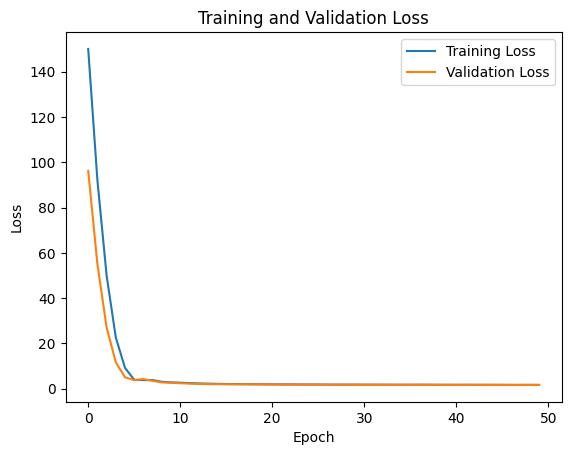

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
stud = pd.read_csv('student.csv')

# Rename columns for better readability
column_names = ['sex', 'age', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'Ssupport', 'ecactivities',
                'internet', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3']
stud.columns = column_names

# Select the most correlated features with the target variable 'G3'
most_correlated = stud.corr().abs()['G3'].sort_values(ascending=False)[:9]
stud = stud[most_correlated.index]

# Encode categorical variables
le = LabelEncoder()
stud_encoded = stud.apply(le.fit_transform)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(stud_encoded.drop('G3', axis=1), stud_encoded['G3'],
                                                    test_size=0.25, random_state=42)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Save the trained model to an HDF5 file
model.save('gradePredict.h5')

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('gradePredict.tflite', 'wb') as f:
    f.write(tflite_model)

# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Example new student's information
new_student_info = {
    'sex': 'female',
    'age': 15,
    'Pstatus': 'A',
    'Medu': 3,
    'Fedu': 2,
    'traveltime': 1,
    'studytime': 3,
    'Ssupport': 'yes',
    'ecactivities': 'yes',
    'internet': 'yes',
    'freetime': 3,
    'goout': 2,
    'health': 4,
    'absences': 5,
    'G1': 70,
    'G2': 90
}

# Convert the dictionary to a DataFrame
new_student_df = pd.DataFrame([new_student_info])

# One-hot encode categorical variables
new_student_encoded = pd.get_dummies(new_student_df, columns=['sex', 'Pstatus', 'Ssupport', 'ecactivities', 'internet'])

# Ensure columns are in the same order as during training
new_student_encoded = new_student_encoded[X_train.columns]

# Make predictions
new_student_prediction = model.predict(new_student_encoded).flatten()[0]

# Print the predicted grade for the new student
print(f'The predicted final grade for the new student is: {new_student_prediction:.2f}')

1/1 [==============================] - 0s 21ms/step
The predicted final grade for the new student is: 81.63
